## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10]

In [16]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Epoch 6/10
50000/50000 [==============================] - 3s 61us/step - loss: 1.4404 - acc: 0.4951 - val_loss: 1.5616 - val_acc: 0.4532
Epoch 7/10
50000/50000 [==============================] - 3s 61us/step - loss: 1.4037 - acc: 0.5093 - val_loss: 1.5375 - val_acc: 0.4605
Epoch 8/10
50000/50000 [==============================] - 3s 61us/step - loss: 1.3683 - acc: 0.5220 - val_loss: 1.5329 - val_acc: 0.4608
Epoch 9/10
50000/50000 [==============================] - 3s 62us/step - loss: 1.3371 - acc: 0.5340 - val_loss: 1.5174 - val_acc: 0.4663
Epoch 10/10
50000/50000 [==============================] - 3s 67us/step - loss: 1.3082 - acc: 0.5430 - val_loss: 1.5111 - val_acc: 0.4661
Numbers of exp: 3, reduce_factor: 0.75, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________

50000/50000 [==============================] - 4s 71us/step - loss: 1.5034 - acc: 0.4681 - val_loss: 1.6925 - val_acc: 0.4078
Epoch 3/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.4063 - acc: 0.5023 - val_loss: 1.6305 - val_acc: 0.4182
Epoch 4/10
50000/50000 [==============================] - 3s 67us/step - loss: 1.3384 - acc: 0.5270 - val_loss: 1.5575 - val_acc: 0.4447
Epoch 5/10
50000/50000 [==============================] - 3s 65us/step - loss: 1.2827 - acc: 0.5472 - val_loss: 1.6264 - val_acc: 0.4120
Epoch 6/10
50000/50000 [==============================] - 3s 66us/step - loss: 1.2284 - acc: 0.5662 - val_loss: 1.5039 - val_acc: 0.4622
Epoch 7/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.1739 - acc: 0.5886 - val_loss: 1.5141 - val_acc: 0.4630
Epoch 8/10
50000/50000 [==============================] - 4s 73us/step - loss: 1.1317 - acc: 0.6035 - val_loss: 1.4928 - val_acc: 0.4703
Epoch 9/10
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 115us/step - loss: 1.8103 - acc: 0.3736 - val_loss: 2.1523 - val_acc: 0.2971
Epoch 2/10
50000/50000 [==============================] - 3s 70us/step - loss: 1.5407 - acc: 0.4575 - val_loss: 3.1221 - val_acc: 0.2196
Epoch 3/10
50000/50000 [==============================] - 3s 67us/step - loss: 1.4279 - acc: 0.4945 - val_loss: 2.4505 - val_acc: 0.2503
Epoch 4/10
50000/50000 [==============================] - 4s 74us/step - loss: 1.3546 - acc: 0.5212 - val_loss: 2.5879 - val_acc: 0.2725
Epoch 5/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.2998 - acc: 0.5437 - val_loss: 4.7545 - val_acc: 0.1777
Epoch 6/10
50000/50000 [==============================] - 4s 73us/step - loss: 1.2464 - acc: 0.5598 - val_loss: 2.4662 - val_acc: 0.2733

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.7904 - acc: 0.3839 - val_loss: 2.8826 - val_acc: 0.2283
Epoch 2/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.5250 - acc: 0.4652 - val_loss: 2.4425 - val_acc: 0.2590
Epoch 3/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.4219 - acc: 0.4998 - val_loss: 2.1314 - val_acc: 0.3119
Epoch 4/10
50000/50000 [==============================] - 4s 71us/step - loss: 1.3423 - acc: 0.5313 - val_loss: 2.0595 - val_acc: 0.3351
Epoch 5/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.2812 - acc: 0.5524 - val_loss: 1.9055 - val_acc: 0.3565
Epoch 6/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.2323 - acc: 0.5696 - val_loss: 1.6943 - val_acc: 0.4119
Epoch 7/10
50000/50000 [==============================] - 4s 70us/step - loss: 1.1836 - acc: 0.5841 - val_loss: 1.8200 - val_ac

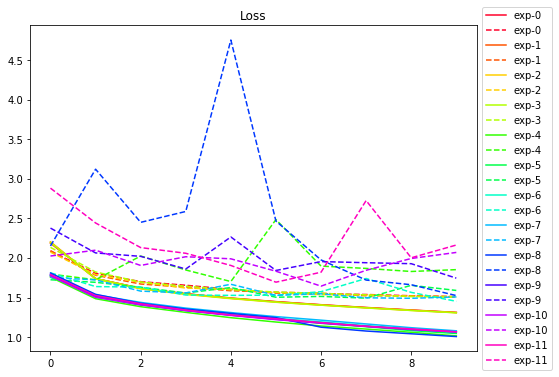

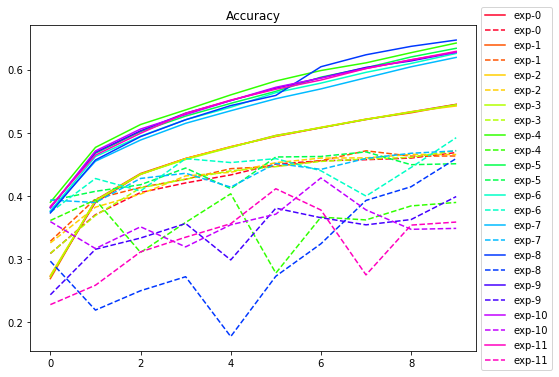

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()